In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from nltk.stem import WordNetLemmatizer
import contractions
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# Load your dataset
df = pd.read_csv(r"C:\Users\kaleeshwaran m\Downloads\tweets.csv")


In [3]:
#Top 10 data
df.head(10)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...
5,6,1,iPhone software update fucked up my phone big ...
6,7,0,Happy for us .. #instapic #instadaily #us #son...
7,8,0,New Type C charger cable #UK http://www.ebay.c...
8,9,0,Bout to go shopping again listening to music #...
9,10,0,Photo: #fun #selfie #pool #water #sony #camera...


In [5]:
#checking data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


In [6]:
#checking null value
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [7]:
#checking duplicated 
df.duplicated().sum()

0

In [12]:
# Check for the class balance
df['label'].value_counts()

label
0    5894
1    2026
Name: count, dtype: int64

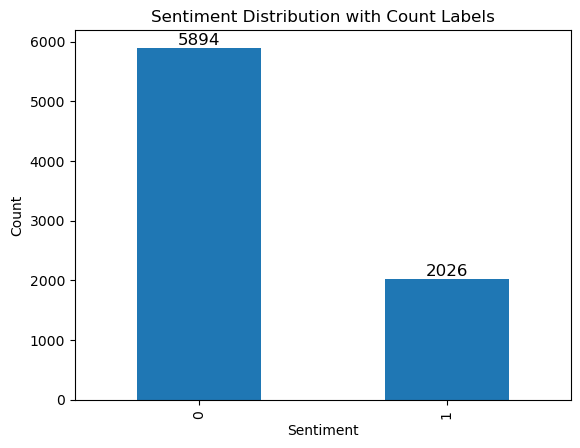

In [16]:
# plot the label counts 
ax = df['label'].value_counts().plot(kind='bar')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# add labels to the axes and a title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution with Count Labels')

plt.show()

In [21]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [55]:
# Clean the tweets (remove URLs, punctuation, extra characters, and lemmatize)
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Remove punctuation and special characters
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Remove extra spaces
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = contractions.fix(tweet)
    words = tweet.split()
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize
    return ' '.join(words)
df['cleaned_tweet_w/o_stopword'] = df['tweet'].apply(clean_tweet)


In [49]:
df.head(10)

,id,label,tweet,cleaned_tweet_w/o_stopword
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint Pregnancy Test android apps beauti...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case Thanks to m...
2,3,0,We love this! Would you go? #talk #makememorie...,We love this Would you go talk makememories un...
3,4,0,I'm wired I know I'm George I was made that wa...,Im wired I know Im George I wa made that way i...
4,5,1,What amazing service! Apple won't even talk to...,What amazing service Apple wont even talk to m...
5,6,1,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...
6,7,0,Happy for us .. #instapic #instadaily #us #son...,Happy for u instapic instadaily u sony xperia ...
7,8,0,New Type C charger cable #UK http://www.ebay.c...,New Type C charger cable UK bay Amazon etsy Ne...
8,9,0,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music i...
9,10,0,Photo: #fun #selfie #pool #water #sony #camera...,Photo fun selfie pool water sony camera picoft...


In [66]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_tweet_with_stopwords'] = df['cleaned_tweet_w/o_stopword'].apply(remove_stopwords)

In [67]:
df.head(10)

,id,label,tweet,cleaned_tweet_w/o_stopword,cleaned_tweet_with_stopwords
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint Pregnancy Test android apps beauti...,fingerprint Pregnancy Test android apps beauti...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case Thanks to m...,Finally transparant silicon case Thanks uncle ...
2,3,0,We love this! Would you go? #talk #makememorie...,We love this Would you go talk makememories un...,We love Would go talk makememories unplug rela...
3,4,0,I'm wired I know I'm George I was made that wa...,I Am wired I know I Am George I wa made that w...,I Am wired I know I Am George I wa made way ip...
4,5,1,What amazing service! Apple won't even talk to...,What amazing service Apple will not even talk ...,What amazing service Apple even talk question ...
5,6,1,iPhone software update fucked up my phone big ...,iPhone software update fucked up my phone big ...,iPhone software update fucked phone big time S...
6,7,0,Happy for us .. #instapic #instadaily #us #son...,Happy for u instapic instadaily u sony xperia ...,Happy u instapic instadaily u sony xperia xperiaZ
7,8,0,New Type C charger cable #UK http://www.ebay.c...,New Type C charger cable UK bay Amazon etsy Ne...,New Type C charger cable UK bay Amazon etsy Ne...
8,9,0,Bout to go shopping again listening to music #...,Bout to go shopping again listening to music i...,Bout go shopping listening music iphone justme...
9,10,0,Photo: #fun #selfie #pool #water #sony #camera...,Photo fun selfie pool water sony camera picoft...,Photo fun selfie pool water sony camera picoft...


In [113]:
df['cleaned_tweet_with_stopwords'][9]

'Photo fun selfie pool water sony camera picoftheday sun instagood boy cute outdoor'

# Data Visualization
#Plot the top 30 most common words in this tweets dataset

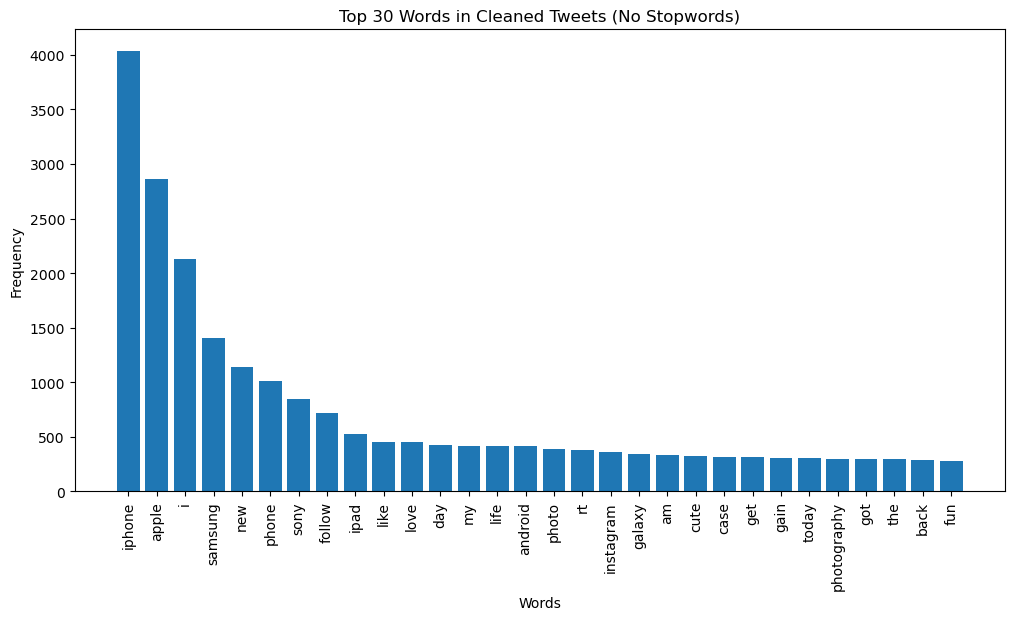

In [150]:
word_count = tokenizer.word_counts
sorted_word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:30])

plt.figure(figsize=(12, 6))
plt.bar(sorted_word_count.keys(), sorted_word_count.values())
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words in Cleaned Tweets (No Stopwords)')
plt.show()

In [69]:

# Tokenize and pad sequences
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_tweet_with_stopwords'])
X = tokenizer.texts_to_sequences(df['cleaned_tweet_with_stopwords'])
X = pad_sequences(X, maxlen=100)  

In [70]:
X

array([[   0,    0,    0, ...,  101,   96,    2],
       [   0,    0,    0, ...,  261,   89, 5746],
       [   0,    0,    0, ...,  114,  297, 1088],
       ...,
       [   0,    0,    0, ...,  110,    4, 2558],
       [   0,    0,    0, ...,   10,    5,  223],
       [   0,    0,    0, ..., 1692,   31,    1]])

In [71]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

In [120]:
# Define the hyperparameter search space
def model_builder(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=max_words, output_dim=128, input_length=100))
    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32)))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [121]:
# Create a tuner instance (RandomSearch)
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,  # You can adjust this as needed
    directory='my_tuning_directory',
    project_name='sentiment_analysis'
)



INFO:tensorflow:Reloading Tuner from my_tuning_directory\sentiment_analysis\tuner0.json


In [122]:
# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64)


INFO:tensorflow:Oracle triggered exit


In [123]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [124]:
# Build and compile the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.compile(optimizer=best_hps.get('optimizer'), loss='binary_crossentropy', metrics=['accuracy'])


In [125]:
# Train the model with the best hyperparameters
best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64)


Epoch 1/10
80/80 [==============================] - 15s 146ms/step - loss: 0.3976 - accuracy: 0.8208 - val_loss: 0.2738 - val_accuracy: 0.8738
Epoch 2/10
80/80 [==============================] - 10s 127ms/step - loss: 0.2149 - accuracy: 0.9116 - val_loss: 0.2651 - val_accuracy: 0.8762
Epoch 3/10
80/80 [==============================] - 10s 127ms/step - loss: 0.1854 - accuracy: 0.9327 - val_loss: 0.2835 - val_accuracy: 0.8707
Epoch 4/10
80/80 [==============================] - 13s 160ms/step - loss: 0.1423 - accuracy: 0.9463 - val_loss: 0.3188 - val_accuracy: 0.8746
Epoch 5/10
80/80 [==============================] - 13s 157ms/step - loss: 0.1152 - accuracy: 0.9576 - val_loss: 0.3524 - val_accuracy: 0.8715
Epoch 6/10
80/80 [==============================] - 13s 158ms/step - loss: 0.1029 - accuracy: 0.9639 - val_loss: 0.3532 - val_accuracy: 0.8715
Epoch 7/10
80/80 [==============================] - 13s 157ms/step - loss: 0.0958 - accuracy: 0.9655 - val_loss: 0.3637 - val_accuracy: 0.8691

In [126]:
# Evaluate the model on the testing dataset
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

50/50 [==============================] - 1s 27ms/step - loss: 0.3752 - accuracy: 0.8699
Accuracy: 86.99%
